**TO DO:** Make a copy of this notebook in your own Google drive and edit the copy.

**TO DO:** Download the data at the following link https://stanfordmlgroup.github.io/competitions/mrnet/ and upload it to your Google Drive.

This will download a folder named 'data'.

*   The dataset consists of 1,250 knee MRIs with image level labels.
*   The training data consists of 1,130 MRIs and the validation data consists of 120 MRIs.
*   They are labelled as abnormal, having an acl tear and/or meniscus tear.
*   Here we focus on binary classification - diseased or not.
*   Each MRI exam includes data from the axial, coronal and sagittal plane.
*   Axial is a Proton-Density series, coronal is a T1-weighted series and sagittal is T2-weighted series.


#### there are 9 combinations
##### no diseases
1.  : Normal
##### disease
2.  abnormal only * 3 palne
3.  ACL tear only * 3 palne
4.  Meniscus tear only * 3 palne







Go to "Edit" on the toolbar, then "Notebook Settings" and change the hardware accelerator to GPU.


#Mount Google Drive to access your data



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The following code uses a python library named 'torchsample'. This is not installed in Google Colab. We can import it by running the commands in the following cell. The exclamation mark communicates to Google Colab to run the commands in the terminal rather than in Python in the current notebook.


In [3]:
# !pip install -e git+https://github.com/ncullen93/torchsample.git#egg=torchsample
!pip install visdom
!pip install nibabel
!pip install h5py
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=3dac53ae0dee391f3269a32852b2b524bf2cedee7193e923e66f590237349503
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built visdom
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.2 MB/s eta 0:00:00


In [4]:
#import all libraries
import torch.optim as optim
import torch
import torch.nn as nn
from torchvision import models
import numpy as np
import os
import time
import shutil
from datetime import datetime
import sys
import pickle
import torch.nn.functional as F
import torch.utils.data as data
import pandas as pd
from torch.autograd import Variable
from torchvision import transforms
from tensorboardX import SummaryWriter
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split  # 导入 train_test_split
from os.path import exists
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

#### check the shape of each plane

In [5]:
# import matplotlib.pyplot as plt
# import numpy as np

# folder = '/content/gdrive/MyDrive/data'
# !ls /content/gdrive/MyDrive/data/train


# image_folder = folder + '/train/axial'
# image = image_folder + '/0000.npy' # select one image
# array = np.load(image) # load MRI
# array.shape
# imgplot = plt.imshow(array[0])


# image_folder1 = folder + '/train/coronal'
# image1 = image_folder1 + '/0000.npy' # select one image
# array1 = np.load(image1) # load MRI
# array1.shape
# imgplot = plt.imshow(array1[0])


# image_folder2 = folder + '/train/sagittal'
# image2 = image_folder2 + '/0000.npy' # select one image
# array2 = np.load(image2) # load MRI
# array2.shape
# imgplot = plt.imshow(array2[0])


#Define your model
The model is defined in the class 'Net'. The 'init' function initialises the architecture of the model.

The line of code; ```self.pretrained_model = models.resnet18(pretrained=True)``` initialises a pre-trained ResNet18, pre-trained on the ImageNet Dataset. This initialises the weights of the model with the weights for a ResNet18 model that was trained on the ImageNet dataset. This speeds up training.

The line of code ```self.classifer = nn.Linear(1000, 1)``` is a fully connected layer that makes the final prediction.

After the model is initialised, the forward function is called iteratively throughout the training process. The output size of each line is shown in the code.

More information con defining models can be found at https://pytorch.org/vision/stable/models.html

In [6]:
models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
list( models.resnet18(pretrained=True).children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
# # 添加 spatial attention
# class SpatialAttention(nn.Module):
#     def __init__(self, kernel_size=7):
#         super(SpatialAttention, self).__init__()

#         self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         x = self.conv1(x)
#         return self.sigmoid(x)


In [9]:
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pretrained_model = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1])  # delete the last fc layer.
#         self.spatial_attention = SpatialAttention()
#         self.classifier = nn.Linear(512, 1)  # change the output of the linear layer to 1

#     def forward(self, x):
#         # input size of x (1, s, 3, 256, 256) where s is the number of slices in one MRI
#         x = torch.squeeze(x, dim=0)  # output size (s, 3, 256, 256)
#         x = self.pretrained_model(x)  # output size (s, 512)

#         # Apply spatial attention
#         x = self.spatial_attention(x) * x  # output size (s, 512)

#         output = torch.max(x, 0, keepdim=True)[0]  # output size (1, 512)
#         output = self.classifier(output.squeeze(2).squeeze(2))  # output size (1)

#         return output

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model =  nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-1]  )    # delete the last fc layer.
        # self.classifer = nn.Linear(512, 1) # change the output of  linear layer to 1
        self.dropout = nn.Dropout(0.5)  # add Dropout layer，value:  0.5
        self.classifer = nn.Linear(512, 1)  # the output of linear layer value: 1

    def forward(self, x):
        # input size of x (1, s, 3, 256, 256) where s is the number of slices in one MRI
        x = torch.squeeze(x, dim=0) #output size (s, 3, 256, 256)
        x = self.pretrained_model(x) #output size (s, 512)
        output = torch.max(x, 0, keepdim=True)[0] #output size (1, 512)
        output = self.classifer(output.squeeze(2).squeeze(2)) #output size (1)

        return output

In [11]:
model =Net()
model

Net(
  (pretrained_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

TO NOTE:
Models defined in Pytorch expect 2D image data in the dimensions (batch size, channels (colours), height of the image, width of the image)

#Create Dataloader
The 'init' function initialises the dataloader. This class is responsible for loading the datasets. It takes the 'root_dir', 'task', 'plane', 'train' and 'transform' as input parameters.
root_dir - the directory to where the data is stored.

task - whether the model is being trained to detect acl tears, meniscus tears or abnormalities. Possible values are 'acl', 'meniscus' or 'abnormal'.

plane - whether the model is being trained on axial, coronal or sagittal data. Possible values are 'axial', 'coronal' or 'sagittal'.

train - is this the dataloader for the training data or the validation data. Possible values are 'True' to load training data or 'False' to load validation data.

transform - a compose function for performing transformations to the images.

The init function creates 1) a list of paths to each MRI, 2) a corresponding list of labels that are either ones or zeros and 3) weights.


---



The __len__ function returns the length of the dataset.


---
The __getitem__ function is iteratively called throughout the training process. It takes an index as a input parameter. It loads the MRI at the given index from the list of paths defined in the init function. It also returns the label and weight for the MRI at that index.



In [12]:
class Dataset(data.Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

        pos = np.sum(self.labels)
        neg = len(self.labels) - pos
        self.weights = [1, neg / pos]

    def __len__(self):
        return len(self.paths)

    def apply_transform(self, array):
        if self.transform:
            transformed_slices = []
            for i in range(array.shape[0]):  # array.shape[0]: slides number
                slice = array[i]       # each slide
                slice = self.transform(slice)
                transformed_slices.append(slice)
            array = torch.cat(transformed_slices, axis=0) # add each transformed slides to array
        return array

    def __getitem__(self, index):
        array = np.load(self.paths[index]) #load MRI
        label = self.labels[index] #get label of MRI
        label = torch.FloatTensor([label]) #convert type from numpy to torch
        array = self.apply_transform(array) #transform the image

        # Normalize the array to 0-1 range
        array = array / 255.0

        array = np.stack((array,)*3, axis=1) #the model expects dimensions of (3, 256, 256), the MRIs are greyscale of size (256, 256). Therefore, we stack the image three times to fit the dimensions for the model.
        array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)

        return array, label, weight


#Train function, Valid function and Test model

In [13]:
def train_model(model, train_loader, epoch, optimizer, writer):

    _ = model.train()

    if torch.cuda.is_available():
      # print('GPU training')
      model.cuda()

    y_preds = []
    y_trues = []
    losses = []
    # criterion = nn.CrossEntropyLoss()
    #loop through each MRI in the training set
    for i, (image, label, weight) in enumerate(train_loader):
      # if i >= 3:
      #     break
      #load all data onto the GPU
      if torch.cuda.is_available():
          image = image.cuda()
          label = label.cuda()
          weight = weight.cuda()
      optimizer.zero_grad()
      #pass the MRI through the model
      prediction = model.forward(image.float())
      #calculate the loss
      loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
      # loss = criterion(prediction, label)

      loss.backward() #back propagation
      optimizer.step()
      loss_value = loss.item()
      losses.append(loss_value)

      probas = torch.sigmoid(prediction) #convert output of model (logits) to a value between zero and one. This can be interpretted as a probability
      # print('probas:', probas)

      y_trues.append(int(label[0]))
      y_preds.append(probas[0].item())

      try:
          auc = metrics.roc_auc_score(y_trues, y_preds)
      except:
          auc = 0.5
      writer.add_scalar('Train/Loss', loss_value,
                          epoch * len(train_loader) + i)
      writer.add_scalar('Train/AUC', auc, epoch * len(train_loader) + i)

    writer.add_scalar('Train/AUC_epoch', auc, epoch + i)
    # print('out of for loop')
    train_loss = np.round(np.mean(losses), 4)
    train_auc = np.round(auc, 4)

    y_preds = np.array(y_preds)
    # train_acc = accuracy_score(y_trues, y_preds.round(), normalize=False)
    # 计算精确率
    train_precision = precision_score(y_trues, y_preds.round())
    # 计算召回率
    train_recall = recall_score(y_trues, y_preds.round())
    # 计算F1分数
    train_f1_score = f1_score(y_trues, y_preds.round())

    return train_loss, train_auc, train_precision, train_recall, train_f1_score

In [14]:
def evaluate_model(model, valid_loader, epoch, writer):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []
    # criterion = nn.CrossEntropyLoss()
    for i, (image, label, weight) in enumerate(valid_loader):
        # if i >= 3:
        #   break
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        prediction = model.forward(image.float())

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
        # loss = criterion(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)
        probas = torch.sigmoid(prediction)
        # print('probas:', probas)
        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5
        writer.add_scalar('Val/Loss', loss_value, epoch * len(valid_loader) + i)
        writer.add_scalar('Val/AUC', auc, epoch * len(valid_loader) + i)

    writer.add_scalar('Val/AUC_epoch', auc, epoch + i)
    val_loss = np.round(np.mean(losses), 4)
    val_auc = np.round(auc, 4)

    y_preds = np.array(y_preds)
    # val_acc = accuracy_score(y_trues, y_preds.round(), normalize=False)
    # 计算精确率
    val_precision = precision_score(y_trues, y_preds.round())
    # 计算召回率
    val_recall = recall_score(y_trues, y_preds.round())
    # 计算F1分数
    val_f1_score = f1_score(y_trues, y_preds.round())

    return val_loss, val_auc, val_precision, val_recall, val_f1_score

In [15]:
def test_model(model, test_loader, writer):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, (image, label, weight) in enumerate(test_loader):
            # if i >= 3:
            #     break
            # print(f"Batch {i} - Label: {label}, Weight: {weight}")
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()
                weight = weight.cuda()

            prediction = model.forward(image.float())

            loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)
            # loss = criterion(prediction, label)

            loss_value = loss.item()
            losses.append(loss_value)

            probas = torch.sigmoid(prediction)
            # print('probas:', probas)

            y_trues.append(int(label[0]))
            y_preds.append(probas[0].item())

    test_loss = np.round(np.mean(losses), 4)
    test_auc = np.round(metrics.roc_auc_score(y_trues, y_preds), 4)

    y_preds = np.array(y_preds)
    # test_acc = accuracy_score(y_trues, y_preds.round(), normalize=False)
    # 计算精确率
    test_precision = precision_score(y_trues, y_preds.round())
    # 计算召回率
    test_recall = recall_score(y_trues, y_preds.round())
    # 计算F1分数
    test_f1_score = f1_score(y_trues, y_preds.round())

    #### confusion matrix ############
    # x-axis: y_prediction, y-axis: y_trues
    cf_matrix = confusion_matrix(y_trues, y_preds.round(), normalize=None)
    # confusion matrix
    ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    ax.title.set_text("Confusion Matrix")
    ax.set_xlabel("y_preds")
    ax.set_ylabel("y_trues")
    # plt.savefig(csv_path.replace(".csv", "_cf_matrix.png"))
    plt.show()
    #### confusion matrix ############

    #### P-R curve ############
    precision, recall, thresholds = precision_recall_curve(y_trues, y_preds)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(recall,precision)
    plt.show()
    #### P-R curve ############

    ### ROC curve #############
    fpr, tpr, _ = roc_curve(y_trues, y_preds)
    plt.plot(fpr, tpr, marker='.', label='ROC Curve (AUC = %0.2f)' % test_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    ### ROC curve #############

    writer.add_scalar('Test/Loss', test_loss)
    # writer.add_scalar('Test/AUC', test_auc)

    print(f"Test Loss: {test_loss}")
    print(f"Test Auc: {test_auc}")

    return test_loss, test_auc, test_precision, test_recall, test_f1_score

##Training model
### 1. split data to train, valid, test set
### 2. Initialise the model, optimiser, scheduler, transformations and data loader
### 3 training the model

In [16]:
# 使用 load_and_split_data 函数分割数据集
# 定义函数以合并 CSV 文件并分割数据集
def load_and_split_data(root_dir, task, plane, test_size=0.2, valid_size=0.2, random_state=42, testing_mode=False):

    np.random.seed(random_state) # keep same value every time

    train_folder = os.path.join(root_dir, 'train', plane)
    valid_folder = os.path.join(root_dir, 'valid', plane)

    train_records = pd.read_csv(os.path.join(root_dir, f'train-{task}.csv'), header=None, names=['id', 'label'])
    valid_records = pd.read_csv(os.path.join(root_dir, f'valid-{task}.csv'), header=None, names=['id', 'label'])

    records = pd.concat([train_records, valid_records], ignore_index=True)

    # 确保生成的文件路径中包含正确长度的文件名
    train_paths = [os.path.join(train_folder, f"{str(filename).zfill(4)}.npy") for filename in train_records['id'].tolist()]
    valid_paths = [os.path.join(valid_folder, f"{str(filename).zfill(4)}.npy") for filename in valid_records['id'].tolist()]

    paths = train_paths + valid_paths
    labels = records['label'].tolist()

    # 如果是测试模式，缩小数据集大小
    if testing_mode:
        paths = paths[:300]
        labels = labels[:300]

    # 第一次分割，获得训练集和临时集（包含验证集和测试集）
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        paths, labels, test_size=(test_size + valid_size), random_state=random_state, stratify=labels
    )

    # 将临时集再分割为验证集和测试集
    valid_paths, test_paths, valid_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=test_size / (test_size + valid_size), random_state=random_state, stratify=temp_labels
    )


    return (train_paths, train_labels), (valid_paths, valid_labels), (test_paths, test_labels)


In [17]:
# check data disribution -> kernel density estimation(KDE)
def check_data_distribution(test_labels):
    test_abnormal = pd.DataFrame(test_labels, columns = ['label'])

    train_set=pd.read_csv('./gdrive/MyDrive/data/train-abnormal.csv')
    # train_set
    valid_set=pd.read_csv('./gdrive/MyDrive/data/valid-abnormal.csv')
    # test_set
    plt.figure(figsize=(8,8))
    ax1 = sns.kdeplot(train_set['1'],label='train_abnormal')
    ax2 = sns.kdeplot(valid_set['0'],label='valid_abnormal')
    ax3 = sns.kdeplot(test_abnormal['label'],label='test_abnormal')

    plt.legend()
    plt.show()

In [18]:
def run_model(lr, num_epochs,directory, task, plane, flush_history, log_every, lr_scheduler, gamma, save_model, prefix_name, step_size):
    ### initialise the model
    model = Net()
    if torch.cuda.is_available(): #if there is a GPU available, put the model on the GPU
        # print('run in GPU')
        model = model.cuda()

    ### splite dataset
    (train_paths, train_labels), (valid_paths, valid_labels), (test_paths, test_labels) = load_and_split_data(directory, task, plane, testing_mode=False)

    check_data_distribution(test_labels)


    ### optimizer setting
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=0.01) #define the optimiser as SGD
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5) #define the optimiser as SGD


    ###  update lr : use two functions change lr
      # patience=4： 连续验证4个epoch没有改善时，时就开始降低学习率； factor=.3： 每次学习率降低为原来的30%； threshold=1e-4： 验证损失减少的阈值，当验证损失减少量大于这个阈值，才代表有改善
      # verbose=True：代表每次调整学习率时都输出相关信息
    if lr_scheduler == "plateau":
        print('into plateau')
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=4, factor=.3, threshold=1e-4)
    elif lr_scheduler == "step":
        print('into step')
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer, step_size=step_size, gamma=gamma)

    ### augmentation
      #define a compose function that is a series of transformations on the images.
    transform = transforms.Compose([
        transforms.ToTensor(),  # chenge numpy array to tensor
        transforms.Normalize(mean=[0.5], std=[0.5]), # standardization, standardise tensor to [-1, 1]
        transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
        transforms.RandomRotation(5),  # 随机旋转图像，最大旋转角度为5度
        transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),  # 随机平移图像
    ])
    # transform for valid set and test set, change image to tensor and normalize data to [0,1]
    valid_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    ### initialise the train and validation datasets (class we defined earlier) and then initialise a Pytorch's dataloader
    print('start dataloader')
    print('directory', directory)
    # train_dataset = Dataset(directory, task, plane, train=True, valid=False, transform = transformer)
    # print('经过了train——dataset')
    # valid_dataset = Dataset(directory, task, plane, train=False, valid=True, transform = None)
    # test_dataset = Dataset(test_paths, test_labels, plane, train=False, valid=False, transform=None)

    train_dataset = Dataset(train_paths, train_labels, transform = transform)
    valid_dataset = Dataset(valid_paths, valid_labels, transform = valid_transform)
    test_dataset = Dataset(test_paths, test_labels, transform = valid_transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=False)
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, drop_last=False)

    # showing each image  (only for test)
    # for i, (image, label, weight) in enumerate(train_loader):
    #   tensor = image[0]
    #   print(tensor.shape)
    #   array = tensor.numpy()
    #   print('array[2].shape',array[2].shape)
    #   image_plt = np.transpose(array[2], (1,2,0))
    #   print('image_plt shape: ',image_plt.shape)
    #   plt.imshow(image_plt)
    #   break
    # return

    ### create log file to record the history of the training process
    log_root_folder = "./logs/{0}/{1}/".format(task, plane)
    if (not exists(log_root_folder)):
      os.makedirs(log_root_folder)
    if flush_history == 1:
        objects = os.listdir(log_root_folder)
        for f in objects:
            if os.path.isdir(log_root_folder + f):
                shutil.rmtree(log_root_folder + f)
    now = datetime.now()
    logdir = log_root_folder + now.strftime("%Y%m%d-%H%M%S") + "/"
    os.makedirs(logdir)
    writer = SummaryWriter(logdir)

    early_trigger = 10 # if the validation AUC hasn't increased in ten epochs, stop the training
    early_stop = 0 #counter for the number of iterations where there has been no increase in validation AUC
    best_val_auc = 0

    t_start_training = time.time()

    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []

    #for loop for each epoch
    for epoch in range(num_epochs):

      t_start = time.time()
      # print(33333)
      train_loss, train_auc, train_precision, train_recall, train_f1_score = train_model(
          model, train_loader, epoch, optimizer, writer)
      # print(4444)
      val_loss, val_auc, val_precision, val_recall, val_f1_score = evaluate_model(
          model, valid_loader, epoch, writer)
      # print(5555)

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      train_aucs.append(train_auc)
      val_aucs.append(val_auc)

      current_lr = scheduler.optimizer.param_groups[0]['lr']

      t_end = time.time()
      delta = t_end - t_start

      print("epoch: {0} / {7} | train loss : {1} | train auc {2} |  train_precision {8} | train_recall {9} | train_f1_score {10} | val loss {3} | val auc {4} | val_precision {11} | val_recall {12} | val_f1_score {13}  | lr {5} | elapsed time {6} s ".format(
          epoch + 1,train_loss, train_auc, val_loss, val_auc, current_lr, delta, num_epochs, train_precision, train_recall, train_f1_score, val_precision, val_recall, val_f1_score))

      print('-' * 100)

      ### save model and set early stop strategy
      if val_auc > best_val_auc:
            best_val_auc = val_auc
            if bool(save_model):
                file_name = f'model_{prefix_name}_{task}_{plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
                # 这里要改一下
                if not os.path.exists('./models/'):
                  os.makedirs('./models/')

                file_name = f'model_{prefix_name}_{task}_{plane}_val_auc_{val_auc:0.4f}_train_auc_{train_auc:0.4f}_epoch_{epoch+1}.pth'
                for f in os.listdir('./models/'):
                    if (task in f) and (plane in f) and (prefix_name in f):
                        os.remove(f'./models/{f}')
                torch.save(model.state_dict(), f'./models/{file_name}')

            best_val_auc = val_auc
            early_stop=0
      else:
            early_stop+= 1

      if early_stop == early_trigger:
        print('Early stopping after {} epochs'.format(epoch))
        test_loss, test_auc, test_precision, test_recall, test_f1_score = test_model(model, test_loader, writer)
        print(f'Final Test Loss: {test_loss} | Final Test Auc: {test_auc} |  Final Test Precision: {test_precision} | Final Test Recall: {test_recall} | Final Test Recall: {test_f1_score}')
        plt.figure(figsize=(6, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Train and Validation Loss over Time')
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.plot(train_aucs, label='Train Auc')
        plt.plot(val_aucs, label='Validation Auc')
        plt.xlabel('Epoch')
        plt.ylabel('Auc')
        plt.legend()
        plt.title('Train and Validation AUC over Time')
        plt.show()


        sys.exit()
        # return

      ### update lr
      if lr_scheduler == 'plateau':
          scheduler.step(val_loss)
      elif lr_scheduler == 'step':
          scheduler.step()


    t_end_training = time.time()
    print(f'training took {t_end_training - t_start_training} s')

    #  use test set as final model performance validation
    test_loss, test_auc, test_precision, test_recall, test_f1_score = test_model(model, test_loader, writer)
    print(f'Final Test Loss: {test_loss} | Final Test Auc: {test_auc} | Final Test Precision: {test_precision} | Final Test Recall: {test_recall} | Final Test Recall: {test_f1_score}')

    plt.figure(figsize=(6, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss over Time')
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(train_aucs, label='Train Auc')
    plt.plot(val_aucs, label='Validation Auc')
    plt.xlabel('Epoch')
    plt.ylabel('Auc')
    plt.legend()
    plt.title('Train and Validation AUC over Time')
    plt.show()


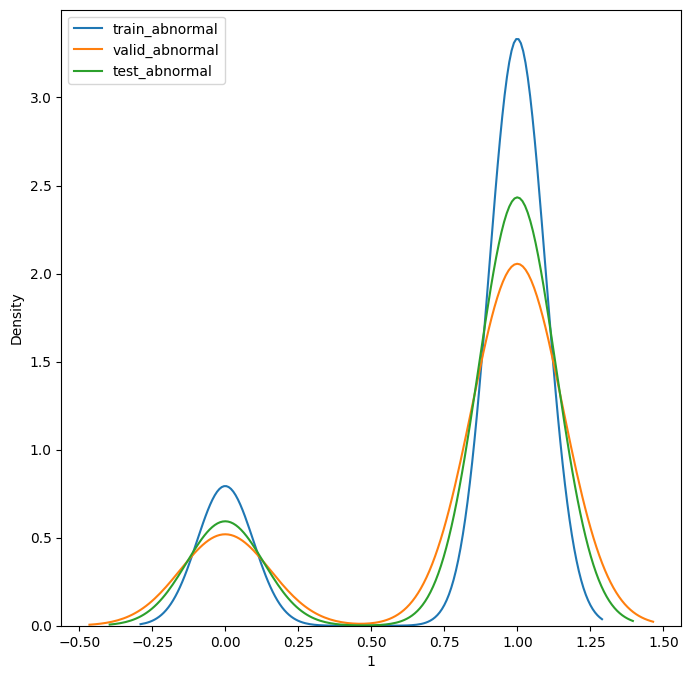

into step
start dataloader
directory ./gdrive/MyDrive/data/
epoch: 1 / 50 | train loss : 0.3484 | train auc 0.5595 |  train_precision 0.8296703296703297 | train_recall 0.4991735537190083 | train_f1_score 0.6233230134158927 | val loss 0.2857 | val auc 0.4968 | val_precision 0.76 | val_recall 0.09405940594059406 | val_f1_score 0.16740088105726875  | lr 0.001 | elapsed time 1801.462076663971 s 
----------------------------------------------------------------------------------------------------
epoch: 2 / 50 | train loss : 0.333 | train auc 0.5581 |  train_precision 0.8447368421052631 | train_recall 0.5305785123966942 | train_f1_score 0.651776649746193 | val loss 0.4987 | val auc 0.6967 | val_precision 0.808 | val_recall 1.0 | val_f1_score 0.8938053097345133  | lr 0.001 | elapsed time 197.06539106369019 s 
----------------------------------------------------------------------------------------------------
epoch: 3 / 50 | train loss : 0.2832 | train auc 0.6656 |  train_precision 0.872641509

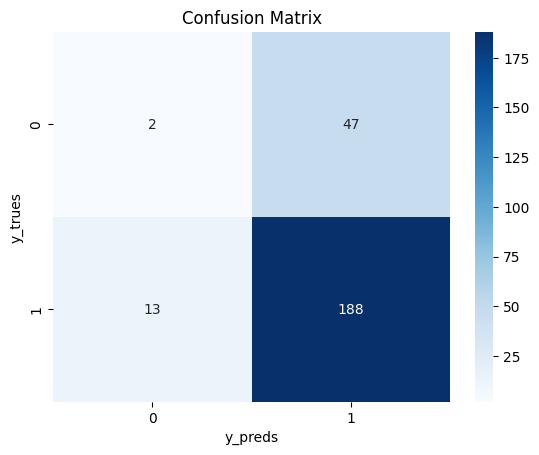

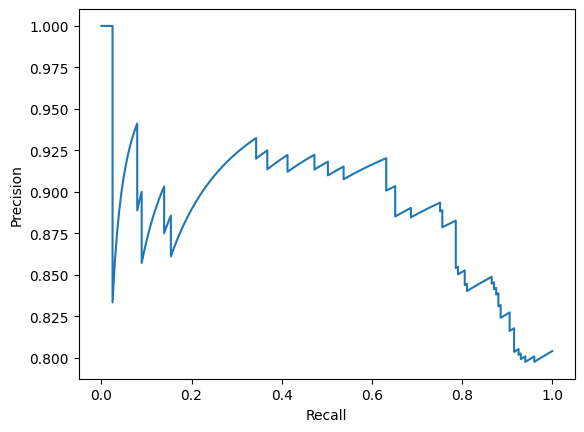

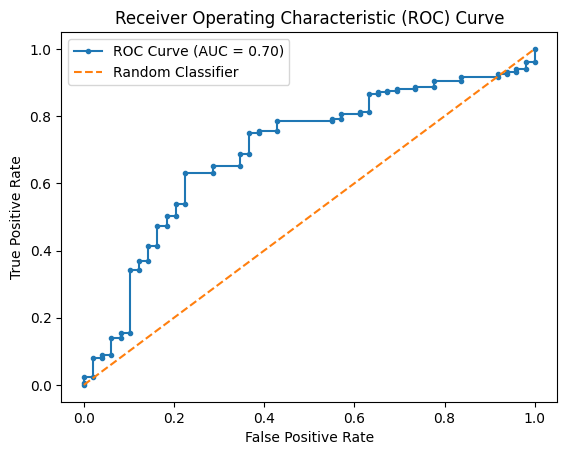

Test Loss: 0.3469
Test Auc: 0.6966
Final Test Loss: 0.3469 | Final Test Auc: 0.6966 |  Final Test Precision: 0.8 | Final Test Recall: 0.9353233830845771 | Final Test Recall: 0.8623853211009174


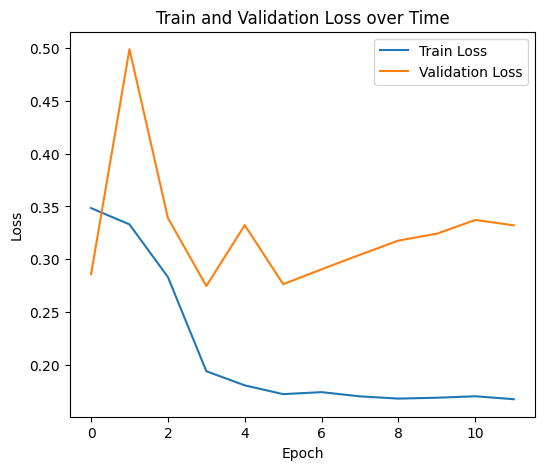

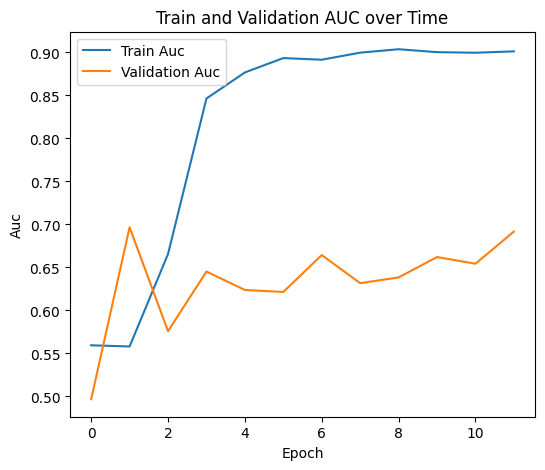

SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
# lr, num_epochs,directory, task, plane, flush_history, log_every, lr_scheduler, gamma, save_model, prefix_name
# lr_scheduler: plateau / step
# axial, coronal and sagittal plane.
# acl tear and/or meniscus tear.
run_model(lr=1e-3, num_epochs=50, directory= './gdrive/MyDrive/data/',
          task='abnormal', plane = 'sagittal', flush_history=1, log_every=100,
          lr_scheduler='step',gamma=0.1,save_model=1, prefix_name='resnet',step_size=3)